The `Grizli` pipeline allows you to fully reduce a given set of HST grism observations with essentially two steps:

* Run an archive query with [`hsaquery`](https://github.com/gbrammer/esa-hsaquery)

* Process the associations found with the query with `grizli.auto_script.go`.

Here, "association" usually simply means "any Hubble exposures that overlap" and doesn't require that all observations were taken with the same observing program, instrument, grism position angle, epoch, filter, etc.  The code does all of the exposure-level book-keeping and the products are drizzled image mosaics, extracted 1D and 2D grism spectra and fits to the spectra.

**NB**: The pipeline works fine with just imaging and no grism exposures!

In [1]:
#cell 1
%matplotlib inline

In [2]:
#cell 2
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import astropy.io.fits as pyfits
import drizzlepac

import grizli
from grizli.pipeline import auto_script 
from grizli import utils
from grizli import fitting
from grizli import multifit #original line, replaced by cell above 

utils.set_warnings()
print('\n Grizli version: ', grizli.__version__)

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol

 Grizli version:  0.8.0-45-g977ade9


In [3]:
#cell 3
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


## Query the HST archive ##

The `hsaquery` module can be used to programaticaly query the HST archive and find exposures from different programs (and instruments) that overlap on the sky.  The example below is tailored for a single pointing from a single program, but the query parameters can be expanded to search much more broadly for archival data.

In [4]:
#cell 4
### Generate a query for the WFC3/ERS grism data

## !! new query tools since ESA database changed in summer 2018
# https://github.com/gbrammer/mastquery
from mastquery import query, overlaps

# "parent" query is grism exposures in GO-11359.  Can also query the archive on position with
# box=[ra, dec, radius_in_arcmin]
parent = query.run_query(box=None, proposal_id=[12945], instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters=['G102','G141'])

# ### "overlap" query finds anything that overlaps with the exposures 
# ### in the parent query
# extra = query.DEFAULT_EXTRA # ignore calibrations, etc.

# ## To match *just* the grism visits, add, e.g., the following:
# extra += ["TARGET.TARGET_NAME LIKE 'WFC3-ERSII-G01'"]

tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                              filters=['F105W', 'F814W','G102'], 
                              proposal_id=[12945], instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC']) 
                              #,extra={'target_name':'CL1059-12.0'}, close=False)

Iter #1, N_Patch = 14


 0 j105908m1246 164.779 -12.773
target_name
-----------
CL1059-12.0 

filter j105908m1246         WFC3/IR F105W    1     811.7
filter j105908m1246          WFC3/IR G102    1    4711.7


 1 j105900m1253 164.747 -12.878
target_name
-----------
        ANY
CL1059-12.1 

filter j105900m1253         ACS/WFC F814W    1     460.0
filter j105900m1253         WFC3/IR F105W    1     811.7
filter j105900m1253          WFC3/IR G102    1    4711.7


 2 j105912m1254 164.794 -12.903
target_name
-----------
CL1059-12.2 

filter j105912m1254         WFC3/IR F105W    1     811.7
filter j105912m1254          WFC3/IR G102    1    4711.7


 3 j105836m1254 164.644 -12.893
target_name
-----------
CL1059-12.3 

filter j105836m1254         WFC3/IR F105W    1     811.7
filter j105836m1254          WFC3/IR G102    1    4711.7


 4 j113812m1134 174.554 -11.573
target_name
-----------
CL1138-11.0 

filter j113812m1134         WFC3/IR F105W    1     811.7
filter j113812m1134          WFC3/IR

In [5]:
#cell 5
# Summary of the tables you just generated
foot_files = glob.glob('j[02]*footprint.fits')
print('Footprint files: ', foot_files)

print('\n# id            ra         dec        e(b-v)   filters')
for tab in tabs:
    print('{0}  {1:.5f}  {2:.5f}   {3:.4f}   {4}'.format(tab.meta['NAME'], tab.meta['RA'], 
                                                 tab.meta['DEC'], tab.meta['MW_EBV'],
                                                  ','.join(np.unique(tab['filter']))))

Footprint files:  []

# id            ra         dec        e(b-v)   filters
j105908m1246  164.77900  -12.77300   0.0281   F105W,G102
j105900m1253  164.74700  -12.87800   0.0273   F105W,F814W,G102
j105912m1254  164.79400  -12.90300   0.0270   F105W,G102
j105836m1254  164.64400  -12.89300   0.0291   F105W,G102
j113812m1134  174.55400  -11.57300   0.0172   F105W,G102
j113848m1134  174.70000  -11.57500   0.0174   F105W,G102
j113736m1125  174.39300  -11.42300   0.0217   F105W,G102
j122756m1136  186.98400  -11.60300   0.0409   F105W,F814W,G102
j122752m1140  186.96700  -11.66100   0.0398   F105W,G102
j122816m1132  187.07100  -11.52800   0.0433   F105W,G102
j130132m1138  195.37900  -11.62600   0.0411   F105W,F814W,G102
j130120m1133  195.34100  -11.54500   0.0415   F105W,G102
j130132m1142  195.38900  -11.69800   0.0407   F105W,F814W,G102
j130100m1131  195.24700  -11.52100   0.0405   F105W,G102


In [6]:
#cell 6
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Pipeline processing - #

** In principle, all of the steps outlined below can be executed with a single call to** `auto_script.go`, from fetching the data to extracting spectra and performing the redshift / line fits.  The processing steps been broken out individually here to show the processing at each step.

** The same pipeline can be used to process imaging-only fields.**  Simply run the queries as above to find the imaging exposures you want to processes and run everything the same way.  The pipeline steps related to the grism exposures will simply be skipped.

In [7]:
#cell 7
# Do everything for the query from fetching the data to generating the contamination model
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

"CHANGE FILE DIRECTORY HERE"
root = 'j105912m1254'
IS_PARALLEL = False # Set to True for parallel programs like WISPS

if False:
    # This line would do everything below
    auto_script.go(root=root, maglim=[19,21], HOME_PATH=HOME_PATH, reprocess_parallel=True, 
                   s3_sync='cp', gaia_by_date=True, is_parallel_field=IS_PARALLEL, 
                   run_fit=False, only_preprocess=True, run_extractions=False)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Individual steps - #

## Fetch data from the HST archive ##
`Grizli` can automatically fetch HST data from the ESA Hubble Science archive (and, optionally, the Amazon S3 bucket).  The `fetch_files` script fetches the exposures listed in the archive query above.  It also fetches associated WFC3/IR persistence products from the persistence database.

The first time you run the script, a lot more information will be printed to the screen as the exposures are retrieved and the script runs the reprocessing code to flatten the IR backgrounds.  Below the "skip" message simply indicate that files have already been downloaded.

In [8]:
#cell 8 THIS TAKES A LONG TIME
### Fetch data, reprocess WFC3/IR for backgrounds, fetch WFC3/IR persistence productss

# If s3_sync, then sync from the Hubble Amazon S3 bucket with awscli, 
# otherwise get from the ESA archive.
os.chdir(HOME_PATH)

import grizli.pipeline
from grizli.pipeline import auto_script
# Is awscli available and connected? 
s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')
if s3_status == 0:
    s3_sync='cp'  # As of late October 2018, 's3 sync' not working with 'stpubdata'
else:
    s3_sync=False # Fetch from ESA archive
    
auto_script.fetch_files(field_root=root, HOME_PATH=HOME_PATH, remove_bad=True, 
                        reprocess_parallel=True, s3_sync=s3_sync)

Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists


## Parse visit associations ##
`Grizli` builds its own associations based on anything it finds in the `RAW` directory.  Visits are usually defined in the exposure filenames.  For example, for the single exposure, `ib6o03ntq_flt.fits`, the characters `b6o` identify the observing program and the visit identifier  is `03`.  You can also build visits combining all exposures in a given filter taken at the same position angle, which can be useful for some programs executed in parallel where exposures taken at a similar time could have different visit IDs in the filename.  

**NB:** Generally one should process "visits" as groups of exposures in a given filter that were taken with a single guide star acquisition.  

The parsing script also associates grism exposures with corresponding direct images, based on the visit, exposure order and exposure footprints on the sky.

In [9]:
#cell 11
# Demo combining by PA / filter.  

# Here it actually gets a bit confused because multiple F098M exposures 
# were taken at the same PA but shouldn't be associated with the grism exposures.
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=True)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1059-12.2-c1b-03-268.0-F105W 4
CL1059-12.2-c1b-03-268.0-G102 4

 == Grism groups ==

ic1b-268.0-f105w 4 ic1b-268.0-g102 4


ic1b-268.0-f105w                4
ic1b-268.0-g102                 4


In [10]:
#cell 12
######################
### Parse visit associations for most normal programs
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=IS_PARALLEL)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1059-12.2-c1b-03-268.0-F105W 4
CL1059-12.2-c1b-03-268.0-G102 4

 == Grism groups ==

cl1059-12.2-c1b-03-268.0-f105w 4 cl1059-12.2-c1b-03-268.0-g102 4


cl1059-12.2-c1b-03-268.0-f105w  4
cl1059-12.2-c1b-03-268.0-g102   4


## Master Pre-processing script: `grizli.prep.process_direct_grism_visit` ##

The `process_direct_grism_visit` script in [prep.py](https://github.com/gbrammer/grizli/blob/master/grizli/prep.py) provides one-stop-shopping for all of the preprocessing steps required.  This includes

* File handling (e.g., copying from `./RAW` to `./Prep/`)
* Astrometric registration
* Grism sky background subtraction & flat-fielding
* Extract visit-level catalogs and segmentation images from the direct imaging

The products of the script for a given direct/grism pair are 

* Aligned, background-subtracted FLTs
* Drizzled mosaics of direct & grism images

The script also runs on *imaging-only* visits, performing the background subtraction and astrometric alignment but skipping anything related to grism processing.

The `auto_script.preprocess` command below runs the processing script for the two direct/grism pairs of the ERS observations and for the overlapping imaging visits identified in the initial query.  It prints a bunch of information to the terminal, primarily from various runs of AstroDrizzle, and takes a few minutes to run per visit.  It only needs to be run once.

**NB** If you restart the pipeline after a previous run, it will skip preprocessing any visit where the file `{visit-product}_dr?_sci.fits` is found (i.e., the "Skip" messages below).  If you want to force reprocessing of a visit, delete that file.

In [11]:
#####################
### Alignment & mosaics    
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# Alignment reference catalogs, searched in this order
catalogs = ['NSC', 'PS1','SDSS','GAIA','WISE'] 
# As of v0.8.0-8, can use the NOAO source catalog (NSC) here, which 
# is defined over much of the sky and appears to be well aligned to GAIA.  
# However, sometimes it's not clear how to apply the best quality control 
# to the NSC sources.  Here, for example, there seem to be a number of spurious 
# NSC sources that make the initial alignment RMS fairly high. 

# This script will do all the preprocessing of the grism *and* imaging visits 
# found in your archive query.
auto_script.preprocess(field_root=root, HOME_PATH=HOME_PATH, 
                       make_combined=False, catalogs=catalogs, use_visit=True)

0 cl1059-12.2-c1b-03-268.0-f105w 4 cl1059-12.2-c1b-03-268.0-g102 4
Skip cl1059-12.2-c1b-03-268.0-f105w
Skip cl1059-12.2-c1b-03-268.0-f105w
Skip cl1059-12.2-c1b-03-268.0-g102
utils.fix_flt_nan: ic1b03koq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b03kvq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b03kqq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b03l4q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b03kgq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b03kxq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b03l2q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b03kjq_flt.fits[SCI,1] NaNPixels=0


In [12]:
!ls wfc3*sci.fits # individual drizzled visits

ls: cannot access wfc3*sci.fits: No such file or directory


In [13]:
# Results of the intra-visit alignment.  
# Should be small as these are just FGS drift on a single guide star
!ls *shifts.log
print('')
!cat *shifts.log

cl1059-12.2-c1b-03-268.0-f105w_shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['ic1b03kgq_flt.fits'] = ['ic1b03kjq_flt.fits']
# match['ic1b03koq_flt.fits'] = ['ic1b03kqq_flt.fits']
# match['ic1b03kvq_flt.fits'] = ['ic1b03kxq_flt.fits']
# match['ic1b03l2q_flt.fits'] = ['ic1b03l4q_flt.fits']
ic1b03kgq_flt.fits   0.000  -0.000  0.00000  1.00000    50  0.000  0.000
ic1b03koq_flt.fits  -0.024   0.077  0.00000  1.00000    43  0.033  0.031
ic1b03kvq_flt.fits  -0.033   0.020  0.00000  1.00000    43  0.058  0.031
ic1b03l2q_flt.fits   0.027   0.037  0.00000  1.00000    44  0.057  0.036


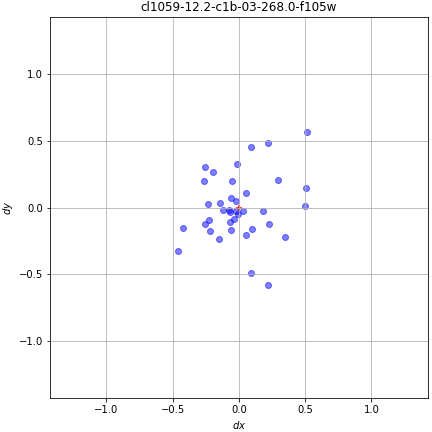

In [14]:
# Show the alignment w.r.t the external NOAO Source Catalog (NSC)
Image(filename = "./cl1059-12.2-c1b-03-268.0-f105w_wcs.png") 


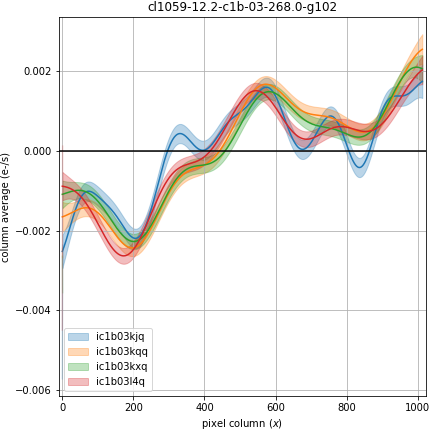

In [15]:
# Show the alignment of one HST visit to another, note tight 
# plot range compared to previous
Image(filename = "./cl1059-12.2-c1b-03-268.0-g102_column.png") 

In [16]:
# Check wcs.log files that a few objects were found, no large rotations
# and rms (second to last column) isn't too large

# Here, the F098M/G102 visit was the first processed and was aligned 
# to the NSC, with RMS~0.8 WFC3/IR pix.  Subsequent visits are aligned to 
# previously processed HST visits so that at least the relative HST astrometry
# is as good as possible.  Here, the F140W/G141 visit was run second and was 
# therefore aligned to F098M, resulting in much better precision than with the
# external catalog (RMS < 0.1 pix).

# Cat wcs.log files in order they were generated
!grep " 0 " `ls -ltr *wcs.log | awk '{print $9}'` | sed "s/  */ /g"

# columns: 
# "visit"  0  xshift yshift rot scale rms N

 0 0.2423 1.8574 0.0102 1.00025 0.203 38


### Alignment failures ###

The main failure mode of the `auto_script.preprocess` script is failure to compute a reliable alignment to the external reference.  This can happen, e.g., if there are not enough alignment sources (i.e., zero) within the field of view or if the original astrometry of the exposures obtained from the archive is offset from the reference by more than ~10 pixels.  This can almost always be remedied by running `grizli.pipeline.auto_script.manual_alignment` after the files have been fetched, which prompts the user to interactively mark sources in the image and reference catalog using DS9.

In [17]:
if False: # Don't run
    catalogs = ['PS1','SDSS','GAIA','WISE']
    auto_script.manual_alignment(field_root=root, HOME_PATH=HOME_PATH, skip=True, 
                                 catalogs=catalogs, radius=15, visit_list=None)

### Grism sky subtraction ###

The grism sky backgrounds are subtracted using the "Master sky" images from [Brammer, Ryan, & Pirzkal 2015](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-17.pdf) (available [here](http://www.stsci.edu/hst/wfc3/analysis/grism_obs/calibrations/wfc3_grism_master_sky.html)).  

`Grizli` ignores any wavelength dependence of the flat-field and applies a grey correction using the F140W (F105W) flat-field for the G141 (G102) grisms.

Residuals after subtracting the master sky images are typically of order 0.005 e-/s, just 0.5-1% overall background level.  They are removed by subtracting a column-average of the sky pixels in the grism exposures, and the processing script produces a diagnostic figure like the one shown below.  The source of the residuals is still unclear (e.g., perhaps spectra of objects near/below the detection limit).  Though they are usually well removed by the column average, they do make extracting continuum spectra of faint sources challenging.

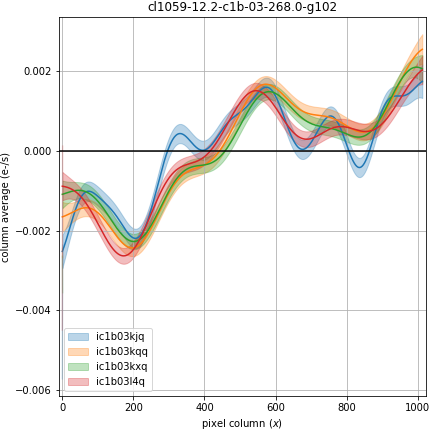

In [18]:
from IPython.display import Image
Image(filename = "./cl1059-12.2-c1b-03-268.0-g102_column.png", width=600, height=600)

### Fine alignment to GAIA DR2 ###

The initial visit alignment scripts often show small drifts such that the differen't visits don't perfectly overlap.  The script below performs an additional realignment to the visits internally and also to an external reference, usually GAIA DR2.

In [19]:
# Fine alignment of the visits relative to each other and absolute to GAIA DR2
if len(glob.glob('{0}*fine.png'.format(root))) == 0:
    fine_catalogs = ['GAIA','PS1','SDSS','WISE']
    out = auto_script.fine_alignment(field_root=root, HOME_PATH=HOME_PATH, 
                                     min_overlap=0.2, stopme=False, ref_err=0.08, 
                                     catalogs=fine_catalogs, NITER=1, maglim=[17,23],
                                     shift_only=True, method='Powell', redrizzle=False, 
                                     radius=10, program_str=None, match_str=[], 
                                     gaia_by_date=True)

    # Update headers with the result from the fine alignment
    # Original FLTs are archived to FineBkup
    auto_script.update_wcs_headers_with_fine(root)
    
visits, res = np.load('{0}_fine.npy'.format(root))
shifts = res.x.reshape((-1,2))/10.
for i, visit in enumerate(visits):
    print('{0:35}  {1:6.2f}  {2:6.2f}'.format(visit['product'], shifts[i,0], shifts[i,1]))

cl1059-12.2-c1b-03-268.0-f105w         0.26   -0.19


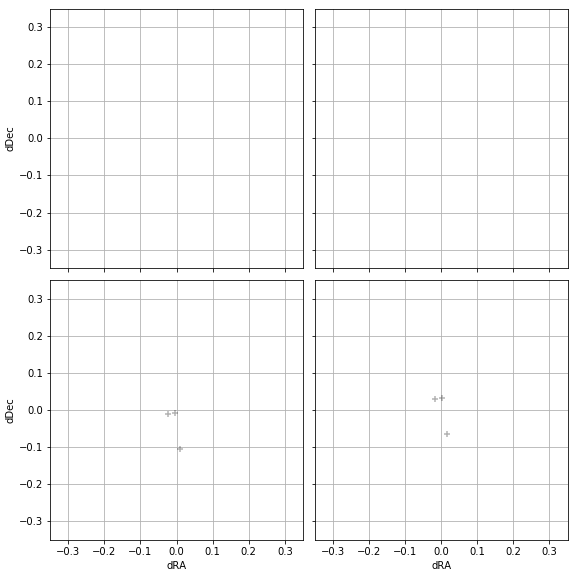

In [20]:
# Show the results of fine alignment.  
# Top panels are alignment between the visits.  + in the bottom panels are 
# residuals of the external reference, here GAIA DR2.
#
# Small drift between individual visits removed.  
# Fairly large GAIA offsets probably due to ~6 years between 
# WFC3/ERS and GAIA epoch 2015.5.
Image(filename='{0}_fine.png'.format(root))

## Make combined mosaics for each available filter ##

These are used to generate a photometric catalog and also for the direct image reference for the grism

In [21]:
# Drizzle mosaics in each filter and combine all IR filters
combine_all_filters=True
if len(glob.glob('{0}-ir_dr?_sci.fits'.format(root))) == 0:

    ## Mosaic WCS
    wcs_ref_file = '{0}_wcs-ref.fits'.format(root)
    if not os.path.exists(wcs_ref_file):
        auto_script.make_reference_wcs(info, output=wcs_ref_file, 
                           filters=['G800L', 'G102', 'G141'], 
                           pad_reference=90, pixel_scale=None,
                           get_hdu=True)

    # All combined
    IR_filters = ['F105W', 'F110W', 'F125W', 'F140W', 'F160W', 
                  'F098M', 'F139M', 'F127M', 'F153M']

    optical_filters = ['F814W', 'F606W', 'F435W', 'F850LP', 'F702W', 'F555W', 'F438W', 'F475W', 'F625W', 'F775W', 'F225W', 'F275W', 'F300W', 'F390W']

    if combine_all_filters:
        auto_script.drizzle_overlaps(root, 
                                 filters=IR_filters+optical_filters, 
                                 min_nexp=1, 
                                 make_combined=True,
                                 ref_image=wcs_ref_file,
                                 drizzle_filters=False) 

    ## IR filters
    auto_script.drizzle_overlaps(root, filters=IR_filters, 
                                 min_nexp=1, 
                                 make_combined=(not combine_all_filters),
                                 ref_image=wcs_ref_file) 

    # Fill IR filter mosaics with scaled combined data so they can be used 
    # as grism reference
    auto_script.fill_filter_mosaics(root)

    ## Optical filters

    mosaics = glob.glob('{0}-ir_dr?_sci.fits'.format(root))

    auto_script.drizzle_overlaps(root, filters=optical_filters,
        make_combined=(len(mosaics) == 0), ref_image=wcs_ref_file,
        min_nexp=2) 

In [22]:
!ls -1 j*_dr?_sci.fits

j105912m1254-f105w_drz_sci.fits
j105912m1254-ir_drz_sci.fits


## Generate a photometric catalog ##

Run source detection on the combined mosaic `{root}-ir_dr[cz]_sci.fits` and generates a catalog and segmentation image.  

Then perform simple matched-aperture photometry on the different available filter mosaics (in this case F098M and F140W from the direct imaging).  In principle the template fitting code shown below can incorporate this photometric information, though that's not currently done by default.

In [23]:
## Run SEP (~SExtractor clone) catalog on the "ir" combined image
## and generate a photometric catalog with aperture photometry in all available bands
if not os.path.exists('{0}_phot.fits'.format(root)):
    get_background=False # SExtractor background subtraction
    tab = auto_script.multiband_catalog(field_root=root, threshold=1.8,
                                        detection_background=get_background,
                                        photometry_background=get_background) 
    
files = glob.glob('{0}-ir*'.format(root)) + glob.glob('*phot*fits')
for file in files:
    print(file)
    
phot = utils.GTable.gread('{0}_phot.fits'.format(root))
print('{0}Metadata{0}'.format('\n'+'='*20+'\n'))
for k in phot.meta:
    print('{0}:\t{1}'.format(k, phot.meta[k]))

j105912m1254-ir_seg.fits
j105912m1254-ir_drz_wht.fits
j105912m1254-ir_bkg.fits
j105912m1254-ir_drz_sci.fits
j105912m1254-ir.cat.fits
j105912m1254_phot.fits

Metadata

MINAREA:	5
CLEAN:	True
DEBCONT:	0.005
DEBTHRSH:	32
FILTER_TYPE:	conv
THRESHOLD:	1.8
ZP:	26.26887001774306
PLAM:	10551.047
FNU:	1.1283712e-07
FLAM:	3.0386574e-20
UJY2DN:	8.861796202091552
DRZ_FILE:	j105912m1254-ir_drz_sci.fits
WHT_FILE:	j105912m1254-ir_drz_wht.fits
GET_BACK:	False
ERR_SCALE:	0.5246511101722717
APER_0:	6.00000000000013
ASEC_0:	0.36
APER_1:	8.33500000000018
ASEC_1:	0.5001
APER_2:	16.33700000000036
ASEC_2:	0.9802200000000001
APER_3:	20.00000000000043
ASEC_3:	1.2
F105W_ZP:	26.26887001774306
F105W_PLAM:	10551.047
F105W_FNU:	1.1283712e-07
F105W_FLAM:	3.0386574e-20
F105W_uJy2dn:	8.861796202091552
F105W_DRZ_FILE:	j105912m1254-f105w_drz_sci.fits
F105W_WHT_FILE:	j105912m1254-f105w_drz_wht.fits
F105W_GET_BACK:	False
F105W_ERR_SCALE:	0.5246511101722717
F105W_aper_0:	6.00000000000013
F105W_asec_0:	0.36
F105W_aper_1:	8.

In [24]:
phot[:2].show_in_notebook()

idx,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x_image,y_image,x2_image,y2_image,xy_image,errx2,erry2,errxy,a_image,b_image,theta_image,cxx_image,cyy_image,cxy_image,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag,number,ra,dec,x_world,y_world,flux_auto,fluxerr_auto,flux_bkg_auto,mag_auto_raw,magerr_auto_raw,mag_auto,magerr_auto,kron_radius,kron_flag,kron_flux_flag,flux_radius,flux_radius_90,flux_aper_0,fluxerr_aper_0,flag_aper_0,bkg_aper_0,mask_aper_0,flux_aper_1,fluxerr_aper_1,flag_aper_1,bkg_aper_1,mask_aper_1,flux_aper_2,fluxerr_aper_2,flag_aper_2,bkg_aper_2,mask_aper_2,flux_aper_3,fluxerr_aper_3,flag_aper_3,bkg_aper_3,mask_aper_3,mag_iso,f105w_flux_aper_0,f105w_fluxerr_aper_0,f105w_flag_aper_0,f105w_bkg_aper_0,f105w_mask_aper_0,f105w_flux_aper_1,f105w_fluxerr_aper_1,f105w_flag_aper_1,f105w_bkg_aper_1,f105w_mask_aper_1,f105w_flux_aper_2,f105w_fluxerr_aper_2,f105w_flag_aper_2,f105w_bkg_aper_2,f105w_mask_aper_2,f105w_flux_aper_3,f105w_fluxerr_aper_3,f105w_flag_aper_3,f105w_bkg_aper_3,f105w_mask_aper_3
,,,,,,,,,,,,,,,,,,,,,,uJy,uJy,uJy,uJy,,,,,,,deg,deg,deg,deg,uJy,uJy,,,,,,pix,,,pix,pix,uJy,uJy,,,,uJy,uJy,,,,uJy,uJy,,,,uJy,uJy,,,,uJy,uJy,uJy,,,,uJy,uJy,,,,uJy,uJy,,,,uJy,uJy,,,
0,0.04333065450191498,6,6,3040,3043,1543,1545,3042.4939405091527,1544.9642536774809,0.890006978445411,0.6568146855745117,-0.339936544407889,0.02180934597135844,0.017204121381069182,-0.007827207037112687,1.0643248558044434,0.6434549689292908,-0.620188295841217,1.4004194736480713,1.8976176977157593,1.4495831727981567,0.03272357472868064,0.0461337948868916,0.006141579493179697,0.011892977349583783,3042,1543,3042,1543,0,1,164.7946844456803,-12.929179369683926,164.7946844456803,-12.929179369683926,0.2488490187087845,0.2248329640174674,0.0,25.41022579097855,0.9809533922354541,25.41022579097855,0.9809533922354541,7.233391224133429,0,0,2.669371370274284,4.166601810194557,0.14634429571698965,0.02714768594283682,0,0.0,2.2000000000000006,0.22414993625479993,0.03652229829737635,0,0.0,5.720000000000002,0.4127815809563172,0.2630103920046208,0,0.0,12.520000000000001,0.4920579105401306,0.3110666588287986,0,0.0,18.880000000000003,27.23995204900666,0.14634429571698965,0.02714768594283682,0,0.0,2.2000000000000006,0.22414993625479993,0.03652229829737635,0,0.0,5.720000000000002,0.4127815809563172,0.2630103920046208,0,0.0,12.520000000000001,0.4920579105401306,0.3110666588287986,0,0.0,18.880000000000003
1,0.029905013740062714,7,5,3047,3050,1545,1548,3049.6441193191445,1547.5151006495225,1.0228555267405013,0.807434962091734,0.308229606135483,0.03289041296256058,0.026819080764627135,0.009269415293390891,1.1142946481704712,0.7672274708747864,0.6173065900802612,1.1047377586364746,1.3994776010513306,-0.8434435129165649,0.03066887223989681,0.043336949750060916,0.005022405424008651,0.0111922888625822,3048,1545,3048,1547,0,2,164.79456217621558,-12.929136855539406,164.79456217621558,-12.929136855539406,0.1565305652261903,0.04680059160808294,0.0,25.913567738614844,0.32462092396822967,25.913567738614844,0.32462092396822967,6.362063751180049,0,0,1.9652002763663279,4.047464714000818,0.11847872237168357,0.03136079081200017,0,0.0,0.12000000000000002,0.1415289557889837,0.041082441184223384,0,0.0,2.6400000000000006,0.20752284544812807,0.08150883760029394,0,0.0,4.0,0.40050550673212415,0.15964463465359516,0,0.0,7.16,27.307854148861182,0.11847872237168357,0.03136079081200017,0,0.0,0.12000000000000002,0.1415289557889837,0.041082441184223384,0,0.0,2.6400000000000006,0.20752284544812807,0.08150883760029394,0,0.0,4.0,0.40050550673212415,0.15964463465359516,0,0.0,7.16


## Building the grism exposure container: `multifit.GroupFLT` ##

With the preprocessing done, we can now start on the analysis of the spectra.  `Grizli` is built around low-level tools for modeling and analyzing each individual grism exposure individually.  Though once multiple exposures are available (e.g., exposures within a visit or separate visits with different grisms and/or orients) the information from each can be combined for analyzing the spectrum of a given object.  A benefit of the exposure-level processing is that all of the model-to-data comparisons (i.e. chi-squared) are done in the space of the original detector pixels, with their well-calibrated and well-understood noise properties.

The `GroupFLT` class provides a container for processing multiple FLT exposures simultanously.

### Inputs ###
* `grism_files` = list of grism exposure filenames
* `direct_files` = (optional) list of direct exposure filenames
* `ref_file` = (optional) reference direct image mosaic (one or the other of `ref_file` or `direct_files` should be specified.)
* `seg_file`, `catalog` = segmentation image and catalog, usually generated with SExtractor
* `cpu_count` = set to > 0 for parallel processing
* `pad` parameter (default=200 pixels).  If set, then add padding around the FLTs to enable modeling of objects that would fall off of the direct image but that still disperse spectra onto the grism exposure (assuming they fall in the `ref_file` and `seg_file` mosaics).

The contents of the `grism_files` list can contain pretty much anything, with the result limited by memory / cpu power.  For example, you can provide a list of **all** 112 of the 3D-HST G141 exposures in the COSMOS field (4 exposures x 28 pointings), along with the field mosaic and segmentation images.  This example is actually fairly easy to process as individual objects will fall in typically 4, perhaps 8 individual exposures in some overlap areas.  Another example is a list of exposures from multiple instruments / grisms / orients of a single field, thought the subsequent fits can be slow if an object has spectra in many individual exposures.

Reference images are blotted to the distorted exposure frame with `AstroDrizzle.ablot`.   Messages go by, as below, when you load the `GroupFLT` object talking about "cutouts" because the script tries to make smaller cutouts of large reference images to speed up the blot processing.

**NB** Seems to often have memory leak problems if `seg_file` isn't significantly larger than the footprint of a given FLT file.  Drizzle `blot` segfaults out but the script just hangs since the multiprocessing threads don't get the message.

### Flat continuum model ###

Once the `GroupFLT` object is initialized, compute a first-pass model of the full detector field of view assuming simple linear continua for all objects in the field (brighter than `mag_limit`).  By default this assumes a somewhat blue continuum suitable for the Rayleigh-Jeans tail of low-redshift objects.  It's far from perfect but the initial model does provide a good way of at least identifying which pixels of a given object could be contaminated by neighbors, even if the quantitative model is not precise.

### Refined polynomial continuum model ###

After computing the simple continuum model, refine the model spectra for brighter objects using higher-order polynomials fit directly to the spectra themselves.  The `refine_list` method marches through objects starting with the brightest and fits a polynomial of order `poly_order` to the observed spectrum after subtracting off the model for contaminants.  Note that if the list of grism exposures contained multiple orientations covering a single field, this fit can be well constrained even in the presence of contamination.

The `grism_prep` script iterates on the refined polynomial model `refine_niter` times.

### Save state ###

You can optionally dump saved data (i.e., `grp.save_full_data()`) for fast restart and avoid recomputing the contamination models, for example in a new Python session.  This can be done at any time after you've made changes to the GroupFLT data that you'd like to store for later.  The `grism_prep` script does this automatically.

In [25]:
files = glob.glob('*GrismFLT.fits')
if len(files) == 0:
    ### Grism contamination model
    os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

    # Which filter to use as direct image?  Will try in order of the list until a match is found.
    gris_ref = {'G141': ['F140W', 'F160W'], 
                'G102': ['F105W', 'F098M', 'F110W']}

    x = auto_script.grism_prep(field_root=root, refine_niter=3,
                                 gris_ref_filters=gris_ref)

    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)
    
else:
    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)

Load ic1b03kxq.01.GrismFLT.fits!
Load ic1b03l4q.01.GrismFLT.fits!
Load ic1b03kqq.01.GrismFLT.fits!
Load ic1b03kjq.01.GrismFLT.fits!
Files loaded - 3.76 sec.


### The final contamination model ###

IndexError: list index out of range

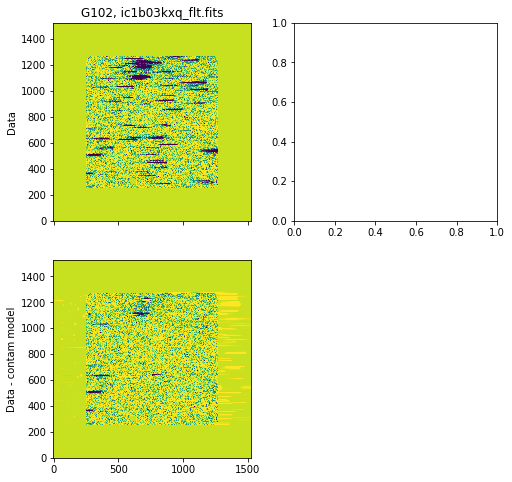

In [26]:
# Show the results of the contamination model
### Show FLT residuals
cmap = 'viridis_r'
vm = [-0.01, 0.1]

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(221)
flt = grp.FLTs[0] # G102

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([])
ax.set_ylabel('Data')

ax = fig.add_subplot(223)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_ylabel('Data - contam model')

ax = fig.add_subplot(222)
flt = grp.FLTs[4] # G141

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([]); ax.set_yticklabels([])

ax = fig.add_subplot(224)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_yticklabels([])

for ax in fig.axes:
    ax.set_xlim(510,790); ax.set_ylim(610,890)

fig.tight_layout(pad=1)

### Parameters for object fitting

In [28]:
h = open('/data2/jrcooper/notebooks/reduction/EDisCS/j105912m1254/Extractions/b_LDP_q.txt', 'r')
lines = h.readlines()[1:]
h.close()   
z_LDP       = []  
id_HST      = []   
ra_HST      = []
dec_HST     = [] 

for line in lines: 
    a = line.split()     
    z_LDP.append(float(a[3]))
    ra_HST.append(float(a[1]))
    dec_HST.append(float(a[2]))



z_LDP     = np.array(z_LDP)
ra_HST    = np.array(ra_HST)
dec_HST   = np.array(dec_HST)
id_HST     = np.array(id_HST) 


In [29]:
#### Store fit parameters to `fit_args.npy` for batch-mode processing

# Drizzle parameters for line maps
pline = auto_script.DITHERED_PLINE
#print(pline) 

sig = 0.007 
z = np.arange(0,2,.001)
for i in z_LDP:
    p_z = np.exp(-(z - i)**2/(2*sig**2))/((2*np.pi)**0.5/sig)

spec_prior = [z,p_z]
tuple
a = tuple(spec_prior)

# Generate the parameter dictionary
args = auto_script.generate_fit_params(field_root=root, prior=a, 
                                       MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                                fsps=True, sys_err = 0.03, fcontam=0.2, zr=[0.05, 3.4], 
                                save_file='fit_args.npy')

Saved arguments to fit_args.npy.


### Field PSF file ### 
Make an average effective PSF for each available IR filter by evaluating the field-dependent PSF across the final mosaic and drizzling to a common output.  Also make an extension with a PSF on the pixel grid of the drizzled line map parameters generated above (`pline`).  Each PSF is generated with the native pixel grid and 2/4x oversampling for use with, e.g., [GALFIT](https://users.obs.carnegiescience.edu/peng/work/galfit/galfit.html).

*NB* There is currently no ePSF for F098M, so F105W is used (http://www.stsci.edu/~jayander/STDPSFs/WFC3IR/).


In [30]:
# Make PSF file
if not os.path.exists('{0}-f105w_psf.fits'.format(root)):
    auto_script.field_psf(root=root, HOME_PATH=HOME_PATH)

['j105912m1254-f105w_psf.fits'] 

Filename: j105912m1254-f105w_psf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  PSF         LINE1 ImageHDU        29   (60, 60)   float32   
  2  PSF         LINE2 ImageHDU        29   (120, 120)   float32   
  3  PSF         LINE4 ImageHDU        29   (240, 240)   float32   
  4  PSF         DRIZ1 ImageHDU        29   (100, 100)   float32   
  5  PSF         DRIZ2 ImageHDU        29   (200, 200)   float32   
  6  PSF         DRIZ4 ImageHDU        29   (400, 400)   float32   


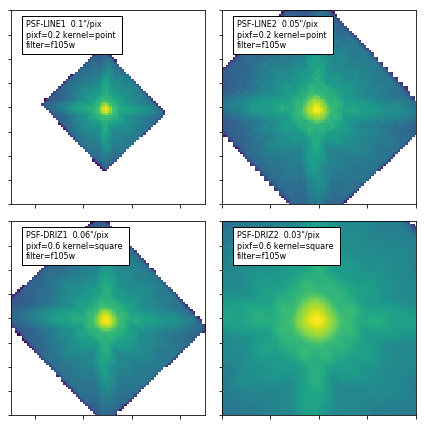

In [31]:
# Show the PSFs
print(glob.glob('*psf.fits'),'\n')

im = pyfits.open('{0}-f105w_psf.fits'.format(root))
im.info()

fig = plt.figure(figsize=[6,6])
for i, ext in enumerate([1,2,4,5]):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(np.log10(im[ext].data))
    
    h = im[ext].header
    label = '{0}-{1}  {2}"/pix \npixf={3} kernel={4} \nfilter={5}'.format(h['EXTNAME'],
                     h['EXTVER'], h['PSCALE'], h['PIXFRAC'], h['KERNEL'], h['FILTER'])
    
    ax.text(0.08, 0.95, label, ha='left', va='top', 
            transform=ax.transAxes, size=8, color='k',
            bbox={'fc':'w'})
    
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    sh = im[ext].data.shape
    ax.set_xlim(sh[1]/2-40, sh[1]/2+40)
    ax.set_ylim(sh[0]/2-40, sh[0]/2+40)
    
fig.tight_layout(pad=1)

## Extract and fit individual spectra ##

In [32]:
os.chdir('../Extractions')

In [33]:
### Find IDs of specific objects to extract
import grizli.pipeline
from grizli.pipeline import auto_script
import astropy.units as u
tab = utils.GTable()
tab['ra'] = ra_HST
tab['dec'] = dec_HST
idx, dr = grp.catalog.match_to_catalog_sky(tab)
source_ids = grp.catalog['NUMBER'][idx]
tab['id'] = source_ids
tab['dr'] = dr.to(u.mas)
tab['dr'].format='.1f'
tab.show_in_notebook()

idx,ra,dec,id,dr
,deg,deg,,mas
0,164.8091844,-12.91329126,109,55.3
1,164.7863456,-12.89473685,362,59.3
2,164.7974827,-12.88888324,423,38.5
3,164.7786867,-12.89817647,318,64.3
4,164.783507,-12.90174307,274,66.2
5,164.7818751,-12.90355518,245,61.2
6,164.796525,-12.92562519,12,85.2
7,164.8058921,-12.90816519,171,36.2
8,164.7999196,-12.89065343,398,40.0


### Extract 2D spectra "beams" ###

The `GroupFLT` object contains the entire exposure information, from which we can make cutouts of spectra for individual objects with the `get_beams` method.  These cutouts are more managable and portable than the entire exposures, though currently the processing does work in the paradigm of having a static contamination model for a given object.  

In pipeline mode, the function below is called with `ids=[], maglim=[mag_min, mag_max]` and all objects in the reference catalog with `mag_min < MAG_AUTO < mag_max` are extracted.  The redshift fits are performed if `run_fit=True`.

In [34]:
for id_i in source_ids:
    auto_script.extract(field_root=root, ids=[id_i], MW_EBV=tabs[0].meta['MW_EBV'], 
                    prior=a, pline=pline, run_fit=True, grp=grp, diff=True)

0/1: 109 4
j105912m1254_00109.beams.fits
0/1: 109
1 ic1b03kxq_flt.fits G102
2 ic1b03l4q_flt.fits G102
3 ic1b03kqq_flt.fits G102
4 ic1b03kjq_flt.fits G102
User templates! N=17 

  0.1000    6912.4 (0.1000) 1/341
  0.1044    6912.0 (0.1044) 2/341
  0.1088    6912.7 (0.1044) 3/341
  0.1133    6913.1 (0.1044) 4/341
  0.1177    6911.6 (0.1177) 5/341
  0.1222    6910.5 (0.1222) 6/341
  0.1267    6911.8 (0.1222) 7/341
  0.1312    6911.4 (0.1222) 8/341
  0.1358    6907.8 (0.1358) 9/341
  0.1403    6904.8 (0.1403) 10/341
  0.1449    6903.2 (0.1449) 11/341
  0.1495    6900.2 (0.1495) 12/341
  0.1541    6897.3 (0.1541) 13/341
  0.1587    6903.4 (0.1541) 14/341
  0.1634    6900.6 (0.1541) 15/341
  0.1680    6902.0 (0.1541) 16/341
  0.1727    6902.6 (0.1541) 17/341
  0.1774    6900.2 (0.1541) 18/341
  0.1821    6899.2 (0.1541) 19/341
  0.1869    6902.8 (0.1541) 20/341
  0.1916    6905.3 (0.1541) 21/341
  0.1964    6899.6 (0.1541) 22/341
  0.2012    6893.9 (0.2012) 23/341
  0.2060    6893.8 (0.2060)

  1.3334    6973.9 (0.4438) 189/341
  1.3427    6972.2 (0.4438) 190/341
  1.3521    6965.3 (0.4438) 191/341
  1.3615    6966.7 (0.4438) 192/341
  1.3710    6976.9 (0.4438) 193/341
  1.3805    6998.5 (0.4438) 194/341
  1.3900    7012.2 (0.4438) 195/341
  1.3996    7021.2 (0.4438) 196/341
  1.4092    7028.0 (0.4438) 197/341
  1.4189    7039.1 (0.4438) 198/341
  1.4286    7040.4 (0.4438) 199/341
  1.4383    7032.2 (0.4438) 200/341
  1.4481    7027.2 (0.4438) 201/341
  1.4579    7032.8 (0.4438) 202/341
  1.4678    7055.9 (0.4438) 203/341
  1.4776    7070.7 (0.4438) 204/341
  1.4876    7070.0 (0.4438) 205/341
  1.4975    7063.3 (0.4438) 206/341
  1.5076    7074.7 (0.4438) 207/341
  1.5176    7068.2 (0.4438) 208/341
  1.5277    7067.3 (0.4438) 209/341
  1.5378    7059.9 (0.4438) 210/341
  1.5480    7039.4 (0.4438) 211/341
  1.5582    7039.3 (0.4438) 212/341
  1.5685    7050.7 (0.4438) 213/341
  1.5788    7041.6 (0.4438) 214/341
  1.5891    7032.2 (0.4438) 215/341
  1.5995    7048.7 (0.4438) 

- 0.4407    6886.5 (0.4407) 39/132
- 0.4412    6886.4 (0.4412) 40/132
- 0.4417    6886.4 (0.4412) 41/132
- 0.4422    6886.3 (0.4422) 42/132
- 0.4427    6886.2 (0.4427) 43/132
- 0.4432    6886.1 (0.4432) 44/132
- 0.4437    6885.8 (0.4437) 45/132
- 0.4442    6885.5 (0.4442) 46/132
- 0.4447    6885.3 (0.4447) 47/132
- 0.4452    6885.2 (0.4452) 48/132
- 0.4457    6885.1 (0.4457) 49/132
- 0.4462    6884.8 (0.4462) 50/132
- 0.4467    6884.7 (0.4467) 51/132
- 0.4472    6884.8 (0.4467) 52/132
- 0.4477    6885.0 (0.4467) 53/132
- 0.4482    6885.2 (0.4467) 54/132
- 0.4487    6885.4 (0.4467) 55/132
- 0.4492    6885.7 (0.4467) 56/132
- 0.4497    6886.0 (0.4467) 57/132
- 0.4502    6886.2 (0.4467) 58/132
- 0.4507    6886.6 (0.4467) 59/132
- 0.4512    6887.0 (0.4467) 60/132
- 0.4517    6887.5 (0.4467) 61/132
- 0.4522    6888.1 (0.4467) 62/132
- 0.4527    6888.6 (0.4467) 63/132
- 0.4532    6889.3 (0.4467) 64/132
- 0.4537    6889.9 (0.4467) 65/132
- 0.4542    6890.6 (0.4467) 66/132
- 2.2770    6890.2 (

  0.5893    7058.1 (0.4554) 93/341
  0.5957    7062.1 (0.4554) 94/341
  0.6021    7067.4 (0.4554) 95/341
  0.6085    7070.3 (0.4554) 96/341
  0.6150    7075.0 (0.4554) 97/341
  0.6214    7082.4 (0.4554) 98/341
  0.6279    7088.2 (0.4554) 99/341
  0.6345    7082.1 (0.4554) 100/341
  0.6410    7071.0 (0.4554) 101/341
  0.6476    7060.3 (0.4554) 102/341
  0.6542    7053.6 (0.4554) 103/341
  0.6608    7040.9 (0.4554) 104/341
  0.6675    7026.2 (0.6675) 105/341
  0.6742    7022.2 (0.6742) 106/341
  0.6809    7031.2 (0.6742) 107/341
  0.6876    7052.9 (0.6742) 108/341
  0.6944    7064.0 (0.6742) 109/341
  0.7012    7067.8 (0.6742) 110/341
  0.7080    7074.8 (0.6742) 111/341
  0.7148    7086.1 (0.6742) 112/341
  0.7217    7094.8 (0.6742) 113/341
  0.7286    7095.6 (0.6742) 114/341
  0.7355    7095.5 (0.6742) 115/341
  0.7425    7091.0 (0.6742) 116/341
  0.7495    7080.7 (0.6742) 117/341
  0.7565    7072.4 (0.6742) 118/341
  0.7635    7066.3 (0.6742) 119/341
  0.7706    7068.0 (0.6742) 120/341

  2.4394    7100.7 (0.6742) 286/341
  2.4532    7091.6 (0.6742) 287/341
  2.4671    7087.2 (0.6742) 288/341
  2.4810    7087.1 (0.6742) 289/341
  2.4949    7087.3 (0.6742) 290/341
  2.5089    7083.7 (0.6742) 291/341
  2.5230    7083.4 (0.6742) 292/341
  2.5371    7087.1 (0.6742) 293/341
  2.5513    7091.7 (0.6742) 294/341
  2.5655    7093.7 (0.6742) 295/341
  2.5798    7092.1 (0.6742) 296/341
  2.5942    7092.1 (0.6742) 297/341
  2.6086    7092.6 (0.6742) 298/341
  2.6230    7091.1 (0.6742) 299/341
  2.6375    7089.8 (0.6742) 300/341
  2.6521    7089.0 (0.6742) 301/341
  2.6668    7086.2 (0.6742) 302/341
  2.6815    7076.9 (0.6742) 303/341
  2.6962    7066.5 (0.6742) 304/341
  2.7110    7061.8 (0.6742) 305/341
  2.7259    7057.2 (0.6742) 306/341
  2.7408    7047.6 (0.6742) 307/341
  2.7558    7040.1 (0.6742) 308/341
  2.7709    7041.9 (0.6742) 309/341
  2.7860    7052.2 (0.6742) 310/341
  2.8012    7063.8 (0.6742) 311/341
  2.8164    7074.0 (0.6742) 312/341
  2.8317    7086.1 (0.6742) 

  0.4496    7600.1 (0.4496) 70/341
  0.4554    7595.7 (0.4554) 71/341
  0.4613    7598.5 (0.4554) 72/341
  0.4671    7608.2 (0.4554) 73/341
  0.4730    7616.1 (0.4554) 74/341
  0.4789    7623.3 (0.4554) 75/341
  0.4848    7629.8 (0.4554) 76/341
  0.4908    7633.9 (0.4554) 77/341
  0.4968    7634.9 (0.4554) 78/341
  0.5028    7635.7 (0.4554) 79/341
  0.5088    7638.2 (0.4554) 80/341
  0.5148    7641.6 (0.4554) 81/341
  0.5209    7640.1 (0.4554) 82/341
  0.5270    7638.4 (0.4554) 83/341
  0.5331    7637.3 (0.4554) 84/341
  0.5393    7639.0 (0.4554) 85/341
  0.5454    7637.1 (0.4554) 86/341
  0.5516    7630.1 (0.4554) 87/341
  0.5579    7618.6 (0.4554) 88/341
  0.5641    7613.3 (0.4554) 89/341
  0.5704    7611.7 (0.4554) 90/341
  0.5767    7611.9 (0.4554) 91/341
  0.5830    7615.1 (0.4554) 92/341
  0.5893    7615.2 (0.4554) 93/341
  0.5957    7620.2 (0.4554) 94/341
  0.6021    7620.1 (0.4554) 95/341
  0.6085    7618.8 (0.4554) 96/341
  0.6150    7618.1 (0.4554) 97/341
  0.6214    7629.4 (

  2.1371    7630.8 (0.4554) 263/341
  2.1497    7633.7 (0.4554) 264/341
  2.1623    7633.2 (0.4554) 265/341
  2.1750    7634.5 (0.4554) 266/341
  2.1877    7638.9 (0.4554) 267/341
  2.2005    7639.9 (0.4554) 268/341
  2.2133    7635.6 (0.4554) 269/341
  2.2262    7631.9 (0.4554) 270/341
  2.2391    7628.0 (0.4554) 271/341
  2.2521    7623.5 (0.4554) 272/341
  2.2652    7617.1 (0.4554) 273/341
  2.2783    7607.2 (0.4554) 274/341
  2.2914    7601.1 (0.4554) 275/341
  2.3046    7602.4 (0.4554) 276/341
  2.3178    7610.0 (0.4554) 277/341
  2.3311    7621.2 (0.4554) 278/341
  2.3445    7629.8 (0.4554) 279/341
  2.3579    7636.6 (0.4554) 280/341
  2.3713    7641.2 (0.4554) 281/341
  2.3849    7643.9 (0.4554) 282/341
  2.3984    7649.2 (0.4554) 283/341
  2.4120    7653.5 (0.4554) 284/341
  2.4257    7653.3 (0.4554) 285/341
  2.4394    7649.9 (0.4554) 286/341
  2.4532    7648.8 (0.4554) 287/341
  2.4671    7649.1 (0.4554) 288/341
  2.4810    7646.5 (0.4554) 289/341
  2.4949    7644.3 (0.4554) 

- 2.7143    7600.7 (0.4566) 114/132
- 2.7148    7600.6 (0.4566) 115/132
- 2.7153    7600.6 (0.4566) 116/132
- 2.7158    7600.6 (0.4566) 117/132
- 2.7163    7600.6 (0.4566) 118/132
- 2.7168    7600.7 (0.4566) 119/132
- 2.7173    7600.7 (0.4566) 120/132
- 2.7178    7600.7 (0.4566) 121/132
- 2.7183    7600.8 (0.4566) 122/132
- 2.7188    7600.8 (0.4566) 123/132
- 2.7193    7600.9 (0.4566) 124/132
- 2.7198    7601.0 (0.4566) 125/132
- 2.7203    7601.1 (0.4566) 126/132
- 2.7208    7601.2 (0.4566) 127/132
- 2.7213    7601.3 (0.4566) 128/132
- 2.7218    7601.4 (0.4566) 129/132
- 2.7223    7601.5 (0.4566) 130/132
- 2.7228    7601.6 (0.4566) 131/132
- 2.7233    7601.8 (0.4566) 132/132
Drizzle line -> SII  (2.04 2.12)
Drizzle line -> Ha   (8.28 2.49)
Drizzle line -> OI-6302 (0.17 3.09)
Get linemap PSF: F105W
0/1: 318 4
j105912m1254_00318.beams.fits
0/1: 318
1 ic1b03kxq_flt.fits G102
2 ic1b03l4q_flt.fits G102
3 ic1b03kqq_flt.fits G102
4 ic1b03kjq_flt.fits G102
User templates! N=17 

  0.1000    65

  1.1368    6593.6 (0.5893) 167/341
  1.1454    6587.3 (0.5893) 168/341
  1.1540    6586.8 (0.5893) 169/341
  1.1626    6592.6 (0.5893) 170/341
  1.1713    6614.0 (0.5893) 171/341
  1.1800    6643.3 (0.5893) 172/341
  1.1887    6673.4 (0.5893) 173/341
  1.1975    6667.8 (0.5893) 174/341
  1.2063    6673.6 (0.5893) 175/341
  1.2151    6689.8 (0.5893) 176/341
  1.2240    6705.9 (0.5893) 177/341
  1.2329    6718.1 (0.5893) 178/341
  1.2419    6733.5 (0.5893) 179/341
  1.2509    6764.3 (0.5893) 180/341
  1.2599    6789.2 (0.5893) 181/341
  1.2689    6781.4 (0.5893) 182/341
  1.2780    6772.0 (0.5893) 183/341
  1.2872    6757.0 (0.5893) 184/341
  1.2963    6760.3 (0.5893) 185/341
  1.3055    6781.6 (0.5893) 186/341
  1.3148    6793.0 (0.5893) 187/341
  1.3240    6798.3 (0.5893) 188/341
  1.3334    6810.8 (0.5893) 189/341
  1.3427    6821.6 (0.5893) 190/341
  1.3521    6811.8 (0.5893) 191/341
  1.3615    6789.8 (0.5893) 192/341
  1.3710    6790.0 (0.5893) 193/341
  1.3805    6800.3 (0.5893) 

- 0.4626    6524.4 (0.4626) 15/99
- 0.4631    6524.2 (0.4631) 16/99
- 0.4636    6524.0 (0.4636) 17/99
- 0.4641    6523.9 (0.4641) 18/99
- 0.4646    6523.9 (0.4641) 19/99
- 0.4651    6524.2 (0.4641) 20/99
- 0.4656    6524.7 (0.4641) 21/99
- 0.4661    6525.1 (0.4641) 22/99
- 0.4666    6525.4 (0.4641) 23/99
- 0.4671    6526.1 (0.4641) 24/99
- 0.4676    6526.9 (0.4641) 25/99
- 0.4681    6527.5 (0.4641) 26/99
- 0.4686    6528.2 (0.4641) 27/99
- 0.4691    6529.4 (0.4641) 28/99
- 0.4696    6530.6 (0.4641) 29/99
- 0.4701    6532.1 (0.4641) 30/99
- 0.4706    6533.6 (0.4641) 31/99
- 0.4711    6535.2 (0.4641) 32/99
- 0.4716    6536.8 (0.4641) 33/99
- 0.5815    6530.0 (0.4641) 34/99
- 0.5820    6528.9 (0.4641) 35/99
- 0.5825    6528.1 (0.4641) 36/99
- 0.5830    6527.2 (0.4641) 37/99
- 0.5835    6526.4 (0.4641) 38/99
- 0.5840    6525.8 (0.4641) 39/99
- 0.5845    6525.3 (0.4641) 40/99
- 0.5850    6524.0 (0.4641) 41/99
- 0.5855    6523.1 (0.5855) 42/99
- 0.5860    6522.8 (0.5860) 43/99
- 0.5865    65

  0.6809    4765.4 (0.4554) 107/341
  0.6876    4782.6 (0.4554) 108/341
  0.6944    4793.6 (0.4554) 109/341
  0.7012    4797.2 (0.4554) 110/341
  0.7080    4798.5 (0.4554) 111/341
  0.7148    4796.9 (0.4554) 112/341
  0.7217    4796.0 (0.4554) 113/341
  0.7286    4792.8 (0.4554) 114/341
  0.7355    4786.7 (0.4554) 115/341
  0.7425    4782.9 (0.4554) 116/341
  0.7495    4778.5 (0.4554) 117/341
  0.7565    4780.0 (0.4554) 118/341
  0.7635    4781.5 (0.4554) 119/341
  0.7706    4782.9 (0.4554) 120/341
  0.7777    4783.1 (0.4554) 121/341
  0.7848    4785.8 (0.4554) 122/341
  0.7920    4782.8 (0.4554) 123/341
  0.7991    4781.1 (0.4554) 124/341
  0.8064    4780.3 (0.4554) 125/341
  0.8136    4774.5 (0.4554) 126/341
  0.8209    4774.8 (0.4554) 127/341
  0.8282    4773.5 (0.4554) 128/341
  0.8355    4766.2 (0.4554) 129/341
  0.8428    4762.2 (0.4554) 130/341
  0.8502    4755.2 (0.4554) 131/341
  0.8576    4750.8 (0.4554) 132/341
  0.8651    4751.0 (0.4554) 133/341
  0.8726    4750.4 (0.4554) 

  2.5655    4752.1 (0.4554) 295/341
  2.5798    4754.6 (0.4554) 296/341
  2.5942    4756.5 (0.4554) 297/341
  2.6086    4758.9 (0.4554) 298/341
  2.6230    4757.2 (0.4554) 299/341
  2.6375    4757.4 (0.4554) 300/341
  2.6521    4759.7 (0.4554) 301/341
  2.6668    4761.3 (0.4554) 302/341
  2.6815    4761.0 (0.4554) 303/341
  2.6962    4757.6 (0.4554) 304/341
  2.7110    4754.0 (0.4554) 305/341
  2.7259    4751.6 (0.4554) 306/341
  2.7408    4751.7 (0.4554) 307/341
  2.7558    4752.7 (0.4554) 308/341
  2.7709    4754.3 (0.4554) 309/341
  2.7860    4755.5 (0.4554) 310/341
  2.8012    4760.5 (0.4554) 311/341
  2.8164    4768.1 (0.4554) 312/341
  2.8317    4772.8 (0.4554) 313/341
  2.8471    4774.0 (0.4554) 314/341
  2.8625    4777.1 (0.4554) 315/341
  2.8780    4782.1 (0.4554) 316/341
  2.8935    4785.1 (0.4554) 317/341
  2.9091    4788.1 (0.4554) 318/341
  2.9248    4790.5 (0.4554) 319/341
  2.9405    4791.5 (0.4554) 320/341
  2.9563    4786.4 (0.4554) 321/341
  2.9722    4776.7 (0.4554) 

  0.4968   11043.5 (0.4554) 78/341
  0.5028   11058.4 (0.4554) 79/341
  0.5088   11066.4 (0.4554) 80/341
  0.5148   11068.1 (0.4554) 81/341
  0.5209   11063.4 (0.4554) 82/341
  0.5270   11063.4 (0.4554) 83/341
  0.5331   11063.0 (0.4554) 84/341
  0.5393   11054.4 (0.4554) 85/341
  0.5454   11036.4 (0.4554) 86/341
  0.5516   11012.5 (0.4554) 87/341
  0.5579   10992.7 (0.4554) 88/341
  0.5641   10971.9 (0.4554) 89/341
  0.5704   10946.1 (0.4554) 90/341
  0.5767   10915.9 (0.4554) 91/341
  0.5830   10880.4 (0.4554) 92/341
  0.5893   10861.0 (0.4554) 93/341
  0.5957   10877.4 (0.4554) 94/341
  0.6021   10914.4 (0.4554) 95/341
  0.6085   10942.3 (0.4554) 96/341
  0.6150   10962.9 (0.4554) 97/341
  0.6214   10974.1 (0.4554) 98/341
  0.6279   10964.6 (0.4554) 99/341
  0.6345   10946.1 (0.4554) 100/341
  0.6410   10935.3 (0.4554) 101/341
  0.6476   10929.5 (0.4554) 102/341
  0.6542   10920.0 (0.4554) 103/341
  0.6608   10911.6 (0.4554) 104/341
  0.6675   10899.8 (0.4554) 105/341
  0.6742   109

  2.2133   10985.8 (0.4554) 269/341
  2.2262   10969.9 (0.4554) 270/341
  2.2391   10954.0 (0.4554) 271/341
  2.2521   10940.3 (0.4554) 272/341
  2.2652   10928.6 (0.4554) 273/341
  2.2783   10922.3 (0.4554) 274/341
  2.2914   10927.3 (0.4554) 275/341
  2.3046   10944.7 (0.4554) 276/341
  2.3178   10969.7 (0.4554) 277/341
  2.3311   11000.6 (0.4554) 278/341
  2.3445   11025.6 (0.4554) 279/341
  2.3579   11044.3 (0.4554) 280/341
  2.3713   11060.6 (0.4554) 281/341
  2.3849   11075.2 (0.4554) 282/341
  2.3984   11085.0 (0.4554) 283/341
  2.4120   11087.3 (0.4554) 284/341
  2.4257   11088.2 (0.4554) 285/341
  2.4394   11089.6 (0.4554) 286/341
  2.4532   11084.8 (0.4554) 287/341
  2.4671   11074.9 (0.4554) 288/341
  2.4810   11066.1 (0.4554) 289/341
  2.4949   11059.9 (0.4554) 290/341
  2.5089   11050.5 (0.4554) 291/341
  2.5230   11036.5 (0.4554) 292/341
  2.5371   11026.4 (0.4554) 293/341
  2.5513   11020.6 (0.4554) 294/341
  2.5655   11014.9 (0.4554) 295/341
  2.5798   11006.1 (0.4554) 

  0.5270    3250.3 (0.3435) 83/341
  0.5331    3250.5 (0.3435) 84/341
  0.5393    3250.6 (0.3435) 85/341
  0.5454    3250.6 (0.3435) 86/341
  0.5516    3250.6 (0.3435) 87/341
  0.5579    3250.6 (0.3435) 88/341
  0.5641    3250.5 (0.3435) 89/341
  0.5704    3250.5 (0.3435) 90/341
  0.5767    3250.4 (0.3435) 91/341
  0.5830    3250.4 (0.3435) 92/341
  0.5893    3250.4 (0.3435) 93/341
  0.5957    3250.5 (0.3435) 94/341
  0.6021    3250.6 (0.3435) 95/341
  0.6085    3250.7 (0.3435) 96/341
  0.6150    3250.7 (0.3435) 97/341
  0.6214    3250.7 (0.3435) 98/341
  0.6279    3250.6 (0.3435) 99/341
  0.6345    3250.5 (0.3435) 100/341
  0.6410    3250.5 (0.3435) 101/341
  0.6476    3250.4 (0.3435) 102/341
  0.6542    3250.4 (0.3435) 103/341
  0.6608    3250.4 (0.3435) 104/341
  0.6675    3250.4 (0.3435) 105/341
  0.6742    3250.3 (0.3435) 106/341
  0.6809    3250.1 (0.3435) 107/341
  0.6876    3250.2 (0.3435) 108/341
  0.6944    3249.2 (0.3435) 109/341
  0.7012    3249.4 (0.3435) 110/341
  0.7080 

  2.3178    3250.0 (1.2509) 277/341
  2.3311    3250.0 (1.2509) 278/341
  2.3445    3249.9 (1.2509) 279/341
  2.3579    3249.9 (1.2509) 280/341
  2.3713    3250.0 (1.2509) 281/341
  2.3849    3250.0 (1.2509) 282/341
  2.3984    3250.0 (1.2509) 283/341
  2.4120    3250.0 (1.2509) 284/341
  2.4257    3250.2 (1.2509) 285/341
  2.4394    3250.5 (1.2509) 286/341
  2.4532    3250.8 (1.2509) 287/341
  2.4671    3251.0 (1.2509) 288/341
  2.4810    3251.2 (1.2509) 289/341
  2.4949    3251.3 (1.2509) 290/341
  2.5089    3251.4 (1.2509) 291/341
  2.5230    3251.5 (1.2509) 292/341
  2.5371    3251.6 (1.2509) 293/341
  2.5513    3251.6 (1.2509) 294/341
  2.5655    3251.6 (1.2509) 295/341
  2.5798    3251.6 (1.2509) 296/341
  2.5942    3251.5 (1.2509) 297/341
  2.6086    3251.7 (1.2509) 298/341
  2.6230    3251.6 (1.2509) 299/341
  2.6375    3251.5 (1.2509) 300/341
  2.6521    3251.4 (1.2509) 301/341
  2.6668    3251.2 (1.2509) 302/341
  2.6815    3251.0 (1.2509) 303/341
  2.6962    3250.9 (1.2509) 

- 0.3356    3249.0 (0.1176) 134/825
- 0.3361    3248.8 (0.1176) 135/825
- 0.3366    3248.7 (0.1176) 136/825
- 0.3371    3248.4 (0.1176) 137/825
- 0.3376    3248.2 (0.1176) 138/825
- 0.3381    3248.0 (0.1176) 139/825
- 0.3386    3247.7 (0.3386) 140/825
- 0.3391    3247.4 (0.3391) 141/825
- 0.3396    3247.1 (0.3396) 142/825
- 0.3401    3246.9 (0.3401) 143/825
- 0.3406    3246.6 (0.3406) 144/825
- 0.3411    3246.4 (0.3411) 145/825
- 0.3416    3246.2 (0.3416) 146/825
- 0.3421    3246.0 (0.3421) 147/825
- 0.3426    3245.9 (0.3426) 148/825
- 0.3431    3245.9 (0.3431) 149/825
- 0.3436    3245.9 (0.3431) 150/825
- 0.3441    3246.0 (0.3431) 151/825
- 0.3446    3246.1 (0.3431) 152/825
- 0.3451    3246.3 (0.3431) 153/825
- 0.3456    3246.6 (0.3431) 154/825
- 0.3461    3246.9 (0.3431) 155/825
- 0.3466    3247.2 (0.3431) 156/825
- 0.3471    3247.6 (0.3431) 157/825
- 0.3476    3247.9 (0.3431) 158/825
- 0.3481    3248.2 (0.3431) 159/825
- 0.3486    3248.5 (0.3431) 160/825
- 0.3491    3248.8 (0.3431) 

- 0.7689    3249.0 (0.3431) 330/825
- 0.8196    3249.1 (0.3431) 331/825
- 0.8201    3249.1 (0.3431) 332/825
- 0.8206    3249.2 (0.3431) 333/825
- 0.8211    3249.2 (0.3431) 334/825
- 0.8216    3249.2 (0.3431) 335/825
- 0.8221    3249.2 (0.3431) 336/825
- 0.8226    3249.2 (0.3431) 337/825
- 0.8231    3249.2 (0.3431) 338/825
- 0.8236    3249.2 (0.3431) 339/825
- 0.8241    3249.2 (0.3431) 340/825
- 0.8246    3249.2 (0.3431) 341/825
- 0.8251    3249.1 (0.3431) 342/825
- 0.8256    3249.1 (0.3431) 343/825
- 0.8261    3249.1 (0.3431) 344/825
- 0.8266    3249.0 (0.3431) 345/825
- 0.8271    3249.0 (0.3431) 346/825
- 0.8276    3249.0 (0.3431) 347/825
- 0.8281    3249.0 (0.3431) 348/825
- 0.8286    3249.0 (0.3431) 349/825
- 0.8291    3248.9 (0.3431) 350/825
- 0.8296    3249.0 (0.3431) 351/825
- 0.8301    3249.0 (0.3431) 352/825
- 0.8306    3249.0 (0.3431) 353/825
- 0.8311    3249.0 (0.3431) 354/825
- 0.8316    3249.1 (0.3431) 355/825
- 0.8321    3249.1 (0.3431) 356/825
- 0.8326    3249.1 (0.3431) 

- 1.6581    3250.3 (1.2513) 527/825
- 1.6586    3250.3 (1.2513) 528/825
- 1.7906    3249.8 (1.2513) 529/825
- 1.7911    3249.8 (1.2513) 530/825
- 1.7916    3249.8 (1.2513) 531/825
- 1.7921    3249.8 (1.2513) 532/825
- 1.7926    3249.8 (1.2513) 533/825
- 1.7931    3249.8 (1.2513) 534/825
- 1.7936    3249.8 (1.2513) 535/825
- 1.7941    3249.8 (1.2513) 536/825
- 1.7946    3249.8 (1.2513) 537/825
- 1.7951    3249.8 (1.2513) 538/825
- 1.7956    3249.8 (1.2513) 539/825
- 1.7961    3249.8 (1.2513) 540/825
- 1.7966    3249.8 (1.2513) 541/825
- 1.7971    3249.8 (1.2513) 542/825
- 1.7976    3249.8 (1.2513) 543/825
- 1.7981    3249.8 (1.2513) 544/825
- 1.7986    3249.8 (1.2513) 545/825
- 1.7991    3249.8 (1.2513) 546/825
- 1.7996    3249.8 (1.2513) 547/825
- 1.8001    3249.8 (1.2513) 548/825
- 1.8006    3249.8 (1.2513) 549/825
- 1.8011    3249.8 (1.2513) 550/825
- 1.8016    3249.8 (1.2513) 551/825
- 1.8021    3249.8 (1.2513) 552/825
- 1.8026    3249.8 (1.2513) 553/825
- 1.8031    3249.8 (1.2513) 

- 2.5497    3251.6 (1.2513) 714/825
- 2.5502    3251.6 (1.2513) 715/825
- 2.5507    3251.6 (1.2513) 716/825
- 2.5512    3251.6 (1.2513) 717/825
- 2.5517    3251.6 (1.2513) 718/825
- 2.5522    3251.6 (1.2513) 719/825
- 2.5527    3251.6 (1.2513) 720/825
- 2.5532    3251.6 (1.2513) 721/825
- 2.5537    3251.6 (1.2513) 722/825
- 2.5542    3251.6 (1.2513) 723/825
- 2.5547    3251.6 (1.2513) 724/825
- 2.5552    3251.6 (1.2513) 725/825
- 2.5557    3251.6 (1.2513) 726/825
- 2.7031    3250.8 (1.2513) 727/825
- 2.7036    3250.8 (1.2513) 728/825
- 2.7041    3250.8 (1.2513) 729/825
- 2.7046    3250.8 (1.2513) 730/825
- 2.7051    3250.7 (1.2513) 731/825
- 2.7056    3250.7 (1.2513) 732/825
- 2.7061    3250.7 (1.2513) 733/825
- 2.7066    3250.7 (1.2513) 734/825
- 2.7071    3250.7 (1.2513) 735/825
- 2.7076    3250.7 (1.2513) 736/825
- 2.7081    3250.7 (1.2513) 737/825
- 2.7086    3250.7 (1.2513) 738/825
- 2.7091    3250.7 (1.2513) 739/825
- 2.7096    3250.7 (1.2513) 740/825
- 2.7101    3250.7 (1.2513) 

  0.5028    7383.3 (0.4613) 79/341
  0.5088    7392.3 (0.4613) 80/341
  0.5148    7393.3 (0.4613) 81/341
  0.5209    7392.7 (0.4613) 82/341
  0.5270    7389.5 (0.4613) 83/341
  0.5331    7386.5 (0.4613) 84/341
  0.5393    7390.9 (0.4613) 85/341
  0.5454    7385.6 (0.4613) 86/341
  0.5516    7382.5 (0.4613) 87/341
  0.5579    7378.7 (0.4613) 88/341
  0.5641    7373.7 (0.4613) 89/341
  0.5704    7369.7 (0.4613) 90/341
  0.5767    7368.0 (0.4613) 91/341
  0.5830    7366.4 (0.4613) 92/341
  0.5893    7364.8 (0.4613) 93/341
  0.5957    7365.0 (0.4613) 94/341
  0.6021    7366.1 (0.4613) 95/341
  0.6085    7371.4 (0.4613) 96/341
  0.6150    7374.5 (0.4613) 97/341
  0.6214    7377.4 (0.4613) 98/341
  0.6279    7377.8 (0.4613) 99/341
  0.6345    7374.8 (0.4613) 100/341
  0.6410    7369.5 (0.4613) 101/341
  0.6476    7358.6 (0.4613) 102/341
  0.6542    7353.6 (0.4613) 103/341
  0.6608    7356.1 (0.4613) 104/341
  0.6675    7359.6 (0.4613) 105/341
  0.6742    7361.7 (0.4613) 106/341
  0.6809    7

  2.2133    7365.0 (0.4613) 269/341
  2.2262    7363.1 (0.4613) 270/341
  2.2391    7362.2 (0.4613) 271/341
  2.2521    7363.7 (0.4613) 272/341
  2.2652    7364.7 (0.4613) 273/341
  2.2783    7364.3 (0.4613) 274/341
  2.2914    7363.8 (0.4613) 275/341
  2.3046    7367.0 (0.4613) 276/341
  2.3178    7374.1 (0.4613) 277/341
  2.3311    7381.5 (0.4613) 278/341
  2.3445    7386.3 (0.4613) 279/341
  2.3579    7387.8 (0.4613) 280/341
  2.3713    7389.0 (0.4613) 281/341
  2.3849    7392.1 (0.4613) 282/341
  2.3984    7397.3 (0.4613) 283/341
  2.4120    7403.5 (0.4613) 284/341
  2.4257    7407.8 (0.4613) 285/341
  2.4394    7406.7 (0.4613) 286/341
  2.4532    7402.6 (0.4613) 287/341
  2.4671    7400.1 (0.4613) 288/341
  2.4810    7400.1 (0.4613) 289/341
  2.4949    7399.9 (0.4613) 290/341
  2.5089    7397.4 (0.4613) 291/341
  2.5230    7394.1 (0.4613) 292/341
  2.5371    7388.3 (0.4613) 293/341
  2.5513    7381.9 (0.4613) 294/341
  2.5655    7377.3 (0.4613) 295/341
  2.5798    7374.5 (0.4613) 

  0.3328    7676.6 (0.1000) 49/341
  0.3382    7672.2 (0.1000) 50/341
  0.3435    7671.7 (0.1000) 51/341
  0.3489    7673.9 (0.1000) 52/341
  0.3543    7675.1 (0.1000) 53/341
  0.3598    7673.5 (0.1000) 54/341
  0.3652    7669.6 (0.1000) 55/341
  0.3707    7664.3 (0.1000) 56/341
  0.3762    7656.6 (0.1000) 57/341
  0.3817    7640.0 (0.1000) 58/341
  0.3872    7628.1 (0.1000) 59/341
  0.3928    7627.9 (0.1000) 60/341
  0.3984    7633.4 (0.1000) 61/341
  0.4040    7641.3 (0.1000) 62/341
  0.4096    7648.3 (0.1000) 63/341
  0.4153    7654.6 (0.1000) 64/341
  0.4209    7664.1 (0.1000) 65/341
  0.4266    7678.5 (0.1000) 66/341
  0.4323    7693.0 (0.1000) 67/341
  0.4381    7699.9 (0.1000) 68/341
  0.4438    7704.0 (0.1000) 69/341
  0.4496    7708.3 (0.1000) 70/341
  0.4554    7711.9 (0.1000) 71/341
  0.4613    7715.5 (0.1000) 72/341
  0.4671    7717.9 (0.1000) 73/341
  0.4730    7718.1 (0.1000) 74/341
  0.4789    7714.5 (0.1000) 75/341
  0.4848    7710.5 (0.1000) 76/341
  0.4908    7707.5 (

  1.9192    7869.1 (0.5957) 245/341
  1.9309    7859.7 (0.5957) 246/341
  1.9426    7844.7 (0.5957) 247/341
  1.9544    7826.1 (0.5957) 248/341
  1.9663    7805.1 (0.5957) 249/341
  1.9782    7787.5 (0.5957) 250/341
  1.9901    7773.7 (0.5957) 251/341
  2.0021    7764.9 (0.5957) 252/341
  2.0141    7756.5 (0.5957) 253/341
  2.0262    7743.9 (0.5957) 254/341
  2.0383    7729.8 (0.5957) 255/341
  2.0505    7713.2 (0.5957) 256/341
  2.0627    7705.2 (0.5957) 257/341
  2.0750    7702.2 (0.5957) 258/341
  2.0873    7701.3 (0.5957) 259/341
  2.0997    7701.1 (0.5957) 260/341
  2.1121    7699.3 (0.5957) 261/341
  2.1246    7696.2 (0.5957) 262/341
  2.1371    7685.1 (0.5957) 263/341
  2.1497    7669.0 (0.5957) 264/341
  2.1623    7657.1 (0.5957) 265/341
  2.1750    7642.3 (0.5957) 266/341
  2.1877    7627.6 (0.5957) 267/341
  2.2005    7628.1 (0.5957) 268/341
  2.2133    7648.5 (0.5957) 269/341
  2.2262    7677.4 (0.5957) 270/341
  2.2391    7693.1 (0.5957) 271/341
  2.2521    7697.3 (0.5957) 

  0.2157    9078.5 (0.1000) 26/341
  0.2206    9079.2 (0.1000) 27/341
  0.2255    9077.4 (0.1000) 28/341
  0.2304    9071.6 (0.2304) 29/341
  0.2353    9065.2 (0.2353) 30/341
  0.2402    9062.9 (0.2402) 31/341
  0.2452    9061.3 (0.2452) 32/341
  0.2502    9060.1 (0.2502) 33/341
  0.2552    9057.5 (0.2552) 34/341
  0.2603    9049.9 (0.2603) 35/341
  0.2653    9048.4 (0.2653) 36/341
  0.2704    9056.2 (0.2653) 37/341
  0.2755    9060.0 (0.2653) 38/341
  0.2806    9058.7 (0.2653) 39/341
  0.2857    9059.0 (0.2653) 40/341
  0.2909    9063.0 (0.2653) 41/341
  0.2960    9063.5 (0.2653) 42/341
  0.3012    9062.6 (0.2653) 43/341
  0.3064    9063.4 (0.2653) 44/341
  0.3117    9063.9 (0.2653) 45/341
  0.3169    9066.4 (0.2653) 46/341
  0.3222    9070.5 (0.2653) 47/341
  0.3275    9072.7 (0.2653) 48/341
  0.3328    9072.5 (0.2653) 49/341
  0.3382    9072.0 (0.2653) 50/341
  0.3435    9071.1 (0.2653) 51/341
  0.3489    9070.5 (0.2653) 52/341
  0.3543    9069.2 (0.2653) 53/341
  0.3598    9067.9 (

  1.5788    9204.2 (0.2653) 214/341
  1.5891    9205.8 (0.2653) 215/341
  1.5995    9208.0 (0.2653) 216/341
  1.6099    9207.3 (0.2653) 217/341
  1.6204    9204.1 (0.2653) 218/341
  1.6309    9197.9 (0.2653) 219/341
  1.6414    9195.3 (0.2653) 220/341
  1.6520    9192.7 (0.2653) 221/341
  1.6626    9192.5 (0.2653) 222/341
  1.6733    9192.0 (0.2653) 223/341
  1.6840    9184.6 (0.2653) 224/341
  1.6948    9177.7 (0.2653) 225/341
  1.7056    9165.3 (0.2653) 226/341
  1.7164    9160.0 (0.2653) 227/341
  1.7273    9155.5 (0.2653) 228/341
  1.7382    9150.7 (0.2653) 229/341
  1.7492    9141.9 (0.2653) 230/341
  1.7602    9132.5 (0.2653) 231/341
  1.7713    9126.1 (0.2653) 232/341
  1.7824    9121.8 (0.2653) 233/341
  1.7935    9114.3 (0.2653) 234/341
  1.8047    9106.6 (0.2653) 235/341
  1.8160    9100.4 (0.2653) 236/341
  1.8273    9092.9 (0.2653) 237/341
  1.8386    9090.4 (0.2653) 238/341
  1.8500    9086.3 (0.2653) 239/341
  1.8614    9080.5 (0.2653) 240/341
  1.8729    9078.9 (0.2653) 

- 0.6632    9055.4 (0.2631) 64/99
- 0.6637    9055.9 (0.2631) 65/99
- 0.6642    9056.5 (0.2631) 66/99
- 0.7109    9058.6 (0.2631) 67/99
- 0.7114    9058.7 (0.2631) 68/99
- 0.7119    9058.7 (0.2631) 69/99
- 0.7124    9058.6 (0.2631) 70/99
- 0.7129    9058.5 (0.2631) 71/99
- 0.7134    9058.5 (0.2631) 72/99
- 0.7139    9058.4 (0.2631) 73/99
- 0.7144    9058.5 (0.2631) 74/99
- 0.7149    9058.4 (0.2631) 75/99
- 0.7154    9058.4 (0.2631) 76/99
- 0.7159    9058.3 (0.2631) 77/99
- 0.7164    9058.2 (0.2631) 78/99
- 0.7169    9058.0 (0.2631) 79/99
- 0.7174    9057.9 (0.2631) 80/99
- 0.7179    9057.8 (0.2631) 81/99
- 0.7184    9057.8 (0.2631) 82/99
- 0.7189    9057.7 (0.2631) 83/99
- 0.7194    9057.6 (0.2631) 84/99
- 0.7199    9057.6 (0.2631) 85/99
- 0.7204    9057.7 (0.2631) 86/99
- 0.7209    9057.7 (0.2631) 87/99
- 0.7214    9057.8 (0.2631) 88/99
- 0.7219    9058.0 (0.2631) 89/99
- 0.7224    9058.1 (0.2631) 90/99
- 0.7229    9058.2 (0.2631) 91/99
- 0.7234    9058.4 (0.2631) 92/99
- 0.7239    90

  1.0204    8344.1 (0.4554) 153/341
  1.0285    8370.1 (0.4554) 154/341
  1.0367    8364.6 (0.4554) 155/341
  1.0448    8367.1 (0.4554) 156/341
  1.0530    8359.1 (0.4554) 157/341
  1.0612    8321.3 (0.4554) 158/341
  1.0695    8302.1 (0.4554) 159/341
  1.0778    8329.9 (0.4554) 160/341
  1.0861    8333.1 (0.4554) 161/341
  1.0945    8352.0 (0.4554) 162/341
  1.1029    8358.7 (0.4554) 163/341
  1.1113    8351.7 (0.4554) 164/341
  1.1198    8342.5 (0.4554) 165/341
  1.1283    8337.4 (0.4554) 166/341
  1.1368    8338.6 (0.4554) 167/341
  1.1454    8351.4 (0.4554) 168/341
  1.1540    8379.4 (0.4554) 169/341
  1.1626    8407.0 (0.4554) 170/341
  1.1713    8454.4 (0.4554) 171/341
  1.1800    8476.4 (0.4554) 172/341
  1.1887    8507.4 (0.4554) 173/341
  1.1975    8576.5 (0.4554) 174/341
  1.2063    8575.8 (0.4554) 175/341
  1.2151    8568.2 (0.4554) 176/341
  1.2240    8571.2 (0.4554) 177/341
  1.2329    8544.2 (0.4554) 178/341
  1.2419    8532.6 (0.4554) 179/341
  1.2509    8559.5 (0.4554) 

  3.2687    8676.5 (0.4554) 340/341
  3.2858    8685.4 (0.4554) 341/341
First iteration: z_best=0.4554

- 0.4475    8284.8 (0.4475) 1/33
- 0.4480    8273.4 (0.4480) 2/33
- 0.4485    8259.4 (0.4485) 3/33
- 0.4490    8243.8 (0.4490) 4/33
- 0.4495    8226.8 (0.4495) 5/33
- 0.4500    8208.3 (0.4500) 6/33
- 0.4505    8188.6 (0.4505) 7/33
- 0.4510    8168.6 (0.4510) 8/33
- 0.4515    8151.0 (0.4515) 9/33
- 0.4520    8133.4 (0.4520) 10/33
- 0.4525    8115.1 (0.4525) 11/33
- 0.4530    8098.7 (0.4530) 12/33
- 0.4535    8084.5 (0.4535) 13/33
- 0.4540    8072.8 (0.4540) 14/33
- 0.4545    8064.4 (0.4545) 15/33
- 0.4550    8060.0 (0.4550) 16/33
- 0.4555    8058.9 (0.4555) 17/33
- 0.4560    8060.7 (0.4555) 18/33
- 0.4565    8066.0 (0.4555) 19/33
- 0.4570    8074.7 (0.4555) 20/33
- 0.4575    8086.2 (0.4555) 21/33
- 0.4580    8100.4 (0.4555) 22/33
- 0.4585    8117.2 (0.4555) 23/33
- 0.4590    8133.6 (0.4555) 24/33
- 0.4595    8150.2 (0.4555) 25/33
- 0.4600    8169.8 (0.4555) 26/33
- 0.4605    8189.2 (0

  1.0043    7947.9 (0.4613) 151/341
  1.0124    7948.6 (0.4613) 152/341
  1.0204    7937.0 (0.4613) 153/341
  1.0285    7920.6 (0.4613) 154/341
  1.0367    7924.8 (0.4613) 155/341
  1.0448    7930.1 (0.4613) 156/341
  1.0530    7921.4 (0.4613) 157/341
  1.0612    7920.9 (0.4613) 158/341
  1.0695    7916.6 (0.4613) 159/341
  1.0778    7916.6 (0.4613) 160/341
  1.0861    7932.6 (0.4613) 161/341
  1.0945    7951.1 (0.4613) 162/341
  1.1029    7946.0 (0.4613) 163/341
  1.1113    7969.0 (0.4613) 164/341
  1.1198    7975.0 (0.4613) 165/341
  1.1283    7941.3 (0.4613) 166/341
  1.1368    7935.1 (0.4613) 167/341
  1.1454    7959.5 (0.4613) 168/341
  1.1540    7972.4 (0.4613) 169/341
  1.1626    8003.4 (0.4613) 170/341
  1.1713    8054.3 (0.4613) 171/341
  1.1800    8097.4 (0.4613) 172/341
  1.1887    8141.8 (0.4613) 173/341
  1.1975    8198.3 (0.4613) 174/341
  1.2063    8239.7 (0.4613) 175/341
  1.2151    8244.6 (0.4613) 176/341
  1.2240    8223.3 (0.4613) 177/341
  1.2329    8194.3 (0.4613) 

- 0.4535    7785.9 (0.4535) 2/33
- 0.4540    7765.6 (0.4540) 3/33
- 0.4545    7742.9 (0.4545) 4/33
- 0.4550    7718.8 (0.4550) 5/33
- 0.4555    7693.8 (0.4555) 6/33
- 0.4560    7669.9 (0.4560) 7/33
- 0.4565    7645.2 (0.4565) 8/33
- 0.4570    7620.5 (0.4570) 9/33
- 0.4575    7597.3 (0.4575) 10/33
- 0.4580    7575.7 (0.4580) 11/33
- 0.4585    7556.7 (0.4585) 12/33
- 0.4590    7540.2 (0.4590) 13/33
- 0.4595    7527.8 (0.4595) 14/33
- 0.4600    7519.4 (0.4600) 15/33
- 0.4605    7514.5 (0.4605) 16/33
- 0.4610    7513.8 (0.4610) 17/33
- 0.4615    7517.7 (0.4610) 18/33
- 0.4620    7525.9 (0.4610) 19/33
- 0.4625    7538.1 (0.4610) 20/33
- 0.4630    7554.0 (0.4610) 21/33
- 0.4635    7571.7 (0.4610) 22/33
- 0.4640    7592.2 (0.4610) 23/33
- 0.4645    7615.0 (0.4610) 24/33
- 0.4650    7638.3 (0.4610) 25/33
- 0.4655    7661.5 (0.4610) 26/33
- 0.4660    7684.9 (0.4610) 27/33
- 0.4665    7708.1 (0.4610) 28/33
- 0.4670    7729.6 (0.4610) 29/33
- 0.4675    7748.8 (0.4610) 30/33
- 0.4680    7768.3 (0.

  1.0285   20126.1 (0.4613) 154/341
  1.0367   20120.2 (0.4613) 155/341
  1.0448   20129.4 (0.4613) 156/341
  1.0530   20144.6 (0.4613) 157/341
  1.0612   20140.7 (0.4613) 158/341
  1.0695   20139.8 (0.4613) 159/341
  1.0778   20144.8 (0.4613) 160/341
  1.0861   20156.4 (0.4613) 161/341
  1.0945   20147.1 (0.4613) 162/341
  1.1029   20161.3 (0.4613) 163/341
  1.1113   20185.1 (0.4613) 164/341
  1.1198   20199.2 (0.4613) 165/341
  1.1283   20199.0 (0.4613) 166/341
  1.1368   20210.0 (0.4613) 167/341
  1.1454   20223.5 (0.4613) 168/341
  1.1540   20250.2 (0.4613) 169/341
  1.1626   20272.6 (0.4613) 170/341
  1.1713   20306.7 (0.4613) 171/341
  1.1800   20340.4 (0.4613) 172/341
  1.1887   20350.1 (0.4613) 173/341
  1.1975   20346.6 (0.4613) 174/341
  1.2063   20373.3 (0.4613) 175/341
  1.2151   20398.8 (0.4613) 176/341
  1.2240   20415.9 (0.4613) 177/341
  1.2329   20427.1 (0.4613) 178/341
  1.2419   20418.5 (0.4613) 179/341
  1.2509   20423.9 (0.4613) 180/341
  1.2599   20437.5 (0.4613) 

- 0.4552   20143.7 (0.4552) 2/33
- 0.4557   20138.2 (0.4557) 3/33
- 0.4562   20133.3 (0.4562) 4/33
- 0.4567   20128.8 (0.4567) 5/33
- 0.4572   20124.5 (0.4572) 6/33
- 0.4577   20120.4 (0.4577) 7/33
- 0.4582   20116.7 (0.4582) 8/33
- 0.4587   20113.4 (0.4587) 9/33
- 0.4592   20110.4 (0.4592) 10/33
- 0.4597   20108.3 (0.4597) 11/33
- 0.4602   20106.4 (0.4602) 12/33
- 0.4607   20104.9 (0.4607) 13/33
- 0.4612   20104.1 (0.4612) 14/33
- 0.4617   20103.1 (0.4617) 15/33
- 0.4622   20102.8 (0.4622) 16/33
- 0.4627   20103.0 (0.4622) 17/33
- 0.4632   20103.6 (0.4622) 18/33
- 0.4637   20104.4 (0.4622) 19/33
- 0.4642   20105.5 (0.4622) 20/33
- 0.4647   20107.0 (0.4622) 21/33
- 0.4652   20108.8 (0.4622) 22/33
- 0.4657   20110.7 (0.4622) 23/33
- 0.4662   20112.7 (0.4622) 24/33
- 0.4667   20114.9 (0.4622) 25/33
- 0.4672   20117.2 (0.4622) 26/33
- 0.4677   20119.6 (0.4622) 27/33
- 0.4682   20122.5 (0.4622) 28/33
- 0.4687   20125.8 (0.4622) 29/33
- 0.4692   20129.0 (0.4622) 30/33
- 0.4697   20132.4 (0.

### 2D spectra ###

The spectral extraction produces two versions of the extracted 2D spectra:

* `{root}_{id:05d}.beams.fits` : Multi-extension FITS file with sets of extensions for 2D cutouts **from each individual grism exposure**.  Fitting in this space is most robust as the grism dispersion is defined in the "FLT" coordinates and the model comparison is done directly on un-resampled image pixels with relatively well-understood noise properties.
    
    
* `{root}_{id:05d}.stack.fits` : Multi-extension FITS file with extension with combinations of all exposures in a given grism & position angle.  The fitting tools can be used with these products as well, where the fits are much faster as 2D models at each trial redshift are produced for `N_PA x N_grism` combinations, where often `N_PA x N_grism << N_exposure`.   The fits are evaluated in the resampled drizzled pixel space, and they are often less robust than fits to the full "beams" spectra, particularly at low S/N.
    
    The `{root}_{id:05d}.stack.png` files, shown below, are often useful for visual inspection of the 2D products.  Note that the bottom panel of the `stack.png` files is the drizzled combination of *all* PAs for a given grism, and with a polynomial continuum model subtracted if `diff=True` in the extraction script above.
    

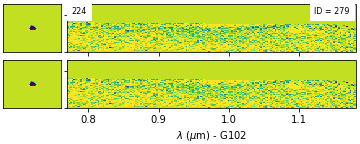

In [51]:
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

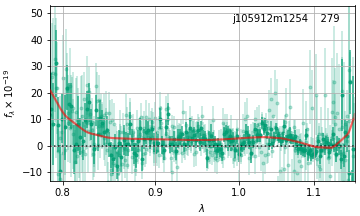

In [52]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

### Redshift fit ###

The redshift fit is performed in the following steps:

* On a coarse redshift grid (dz/1+z ~ 0.005) fit continuum templates along with **line complex** templates for a) [OII]+[NeIII], b) [OIII]+Hbeta, and c) Halpha+[SII]+weaker red lines.  These line complexes have fixed line ratios but are useful for breaking redshift degeneracies as these lines do, usually, come in groups.  Leaving all line strengths free would allow for perfect degeneracy between, e.g., Halpha and [OII] (assuming no significant continuum features).

* Find peaks (minima) in the chi-squared on the coarse grid and zoom in on them now allowing for more freedom in the indifidual line strengths, as well as fitting on a fine redshift grid sufficient to resolve the best redshift.

**NB** Continuum templates are needed in the directory `${GRIZLI}/templates`.  The template names are currently hard-coded in [multifit.py](https://github.com/gbrammer/grizli/blob/master/grizli/multifit.py) and the easiest way to make them available is to symlink them from the `data/templates` directory that accompanies the `grizli` code distribution:


### Emission line maps ###

Once we've computed the full continuum + line model, we can create 2D *drizzled* maps at any desired output wavelength, for example to make emission line maps.  This makes use of the WCS information in the individual grism FLT exposures and the outputs can have any desired WCS (e.g., pixel scale & dimensions) and can be used to compare directly to imaging data.

The emission line maps are generated by subtracting the best-fit continuum model, assuming that the direct image is representative of the continuum morphology.  This should be a reasonable assumption for objects other than, perhaps, those with extreme line equivalent widths.


In [36]:
# Fit it.  The "run_all_parallel" function defaults to all of the parameters set in 'fit_args.npy'
for id_i in source_ids:
    fitting.run_all_parallel(id_i)

Run 10
Run 109
Run 208
Run 413
Run 297
Run 469
Run 469
Run 442
Run 371
Run 297
Run 208
Run 208
Run 469
Run 208
Run 208
Run 208
Run 297
Run 208
Run 297
Run 469
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 281
Run 208
Run 208
Run 208
Run 208
Run 208
Run 208
Run 208
Run 208
Run 208
Run 208
Run 208
Run 208
Run 208
Run 208
Run 12
Run 66
Run 169
Run 171
Run 191
Run 231
Run 245
Run 254
Run 274
Run 299
Run 307
Run 318
Run 323
Run 208
Run 362
Run 331
Run 279
Run 398
Run 407
Run 422
Run 279
Run 423
Run 208
Run 331
Run

### Fit products ###

A number of files are produced that contain the results of the redshift fit.  The [`NewSpectrumFits.ipynb`](https://github.com/gbrammer/grizli/blob/master/examples/NewSpectrumFits.ipynb) notebook describes how to interact with these products in some greater detail.  

In [54]:
files = glob.glob('*{0:05d}*'.format(id))
for file in files:
    print(file)

j105912m1254_00279.full.png
j105912m1254_00279.full.fits
j105912m1254_00279.line.png
j105912m1254_00279.beams.fits
j105912m1254_00279.log_par
j105912m1254_00279.1D.png
j105912m1254_00279.stack.png
j105912m1254_00279.stack.fits
j105912m1254_00279.1D.fits


In [40]:
for file in files:
    if not file.endswith('.fits'):
        continue
        
    im = pyfits.open(file)
    print('\n\n{1}\n{0}\n{1}\n\n'.format(file, '='*len(file)))
    im.info()

### Continuum-dominated spectra ###

The object below is the dominated by strong Balmer break and absorption lines (see [van Dokkum & Brammer 2010](http://adsabs.harvard.edu/abs/2010ApJ...718L..73V)).  The redshift fit and spectral constraints are precise even without any supporting photometric data.

In [56]:
# Continuum source
id=source_ids[1]
auto_script.extract(field_root=root, ids=[id], MW_EBV=tabs[0].meta['MW_EBV'], 
                    pline=pline, run_fit=False, grp=grp, diff=True)

0/1: 453 1
j105912m1254_00453.beams.fits


True

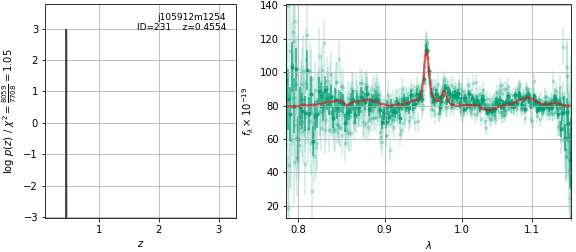

In [38]:
# Stacked 2D spectrum
Image(filename='j105912m1254_00231.full.png') 

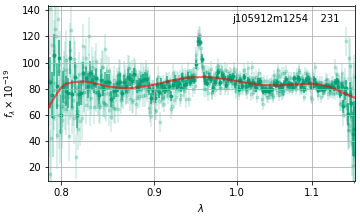

In [39]:
# 1D spectrum with polynomial model
Image(filename='j105912m1254_00231.1D.png') 

Run 453


(453, 1, 5.72208046913147)

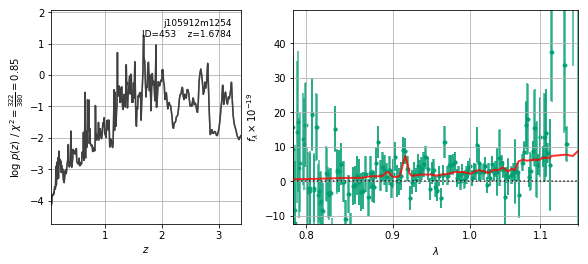

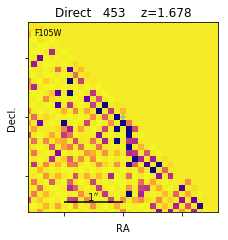

In [59]:
## Run the fit
fitting.run_all_parallel(id)

### Fit grism with photometry

Another option is fitting the grism spectra along with ancillary photometry, described here: [Fit-with-Photometry.ipynb](https://github.com/gbrammer/grizli/blob/master/examples/Fit-with-Photometry.ipynb).